In [47]:
import pandas as pd
import pgmpy as pgm
import numpy as np
import mord
from scipy import stats

### Load in data

In [48]:
mat = pd.read_csv("student-mat.csv", delimiter=';')
por = pd.read_csv("student-por.csv", delimiter=';')

mat['subject'] = pd.Series(np.full((mat.shape[0],), fill_value='mat', dtype=object), index=mat.index)
por['subject'] = pd.Series(np.full((por.shape[0],), fill_value='por', dtype=object), index=por.index)

df = pd.concat([mat, por])

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,mat
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,mat
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,mat
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,mat
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,mat


## PgmPy

In [53]:
def test_independence(df, var1, var2, condition_vars=None):
    """
    Test for the independence condition (var1 _|_ var2 | condition_vars) in df.

    Parameters
    ----------
    df: pandas Dataframe
        The dataset on which to test the independence condition.

    var1: str
        First variable in the independence condition.

    var2: str
        Second variable in the independence condition

    condition_vars: list
        List of variable names in given variables.

    Returns
    -------
    chi_stat: float
        The chi-square statistic for the test.

    p_value: float
        The p-value of the test

    dof: int
        Degrees of Freedom

    Examples
    --------
    >>> df = pd.read_csv('adult.csv')
    >>> chi, p, dof = test_independence(df, var1='Age', var2='Immigrant')
    >>> print("chi =", chi, "\np =", p, "\ndof =",dof)
    chi = 57.7514122288
    p = 8.60514815766e-12
    dof = 4
    >>> chi, p, dof = test_independence(df, var1='Education', var2='HoursPerWeek',
    ...                                 condition_vars=['Age', 'Immigrant', 'Sex'])
    >>> print("chi=", chi, "\np=", p, "\ndof=",dof)
    chi = 1360.65856663 
    p = 0.0 
    dof = 171
    """
    if not condition_vars:
        observed = pd.crosstab(df[var1], df[var2])
        chi_stat, p_value, dof, expected = stats.chi2_contingency(observed)

    else:
        observed_combinations = df.groupby(condition_vars).size().reset_index()
        chi_stat = 0
        dof = 0
        for combination in range(len(observed_combinations)):
            df_conditioned = df.copy()
            for condition_var in condition_vars:
                df_conditioned = df_conditioned.loc[df_conditioned.loc[:, condition_var] == observed_combinations.loc[combination, condition_var]]
            observed = pd.crosstab(df_conditioned[var1], df_conditioned[var2])
            chi, _, freedom, _ = stats.chi2_contingency(observed)
            chi_stat += chi
            dof += freedom
        p_value = 1.0 - stats.chi2.cdf(x=chi_stat, df=dof)

    return chi_stat, p_value, dof

### For defining the network in python, the package pgmpy can be used but it will work only for directed graphs.
from pgmpy.models import BayesianModel

model = BayesianModel([
    ('absences', 'G3'),
    ('activities', 'freetime'),
    ('age', 'activities'),
    ('age', 'romantic'),
    ('age', 'studytime'),
    ('failures', 'G3'),
    ('failures', 'paid'),
    ('failures', 'schoolsup'),
    ('failures', 'studytime'),
    ('famrel', 'famsup'),
    ('famrel', 'paid'),
    ('famsup', 'G3'),
    ('famsup', 'paid'),
    ('famsup', 'studytime'),
    ('Fedu', 'Fjob'),
    ('Fedu', 'higher'),
    ('Fjob', 'famrel'),
    ('freetime', 'G3'),
    ('goout', 'freetime'),
    ('freetime', 'studytime'),
    ('goout', 'romantic'),
    ('health', 'absences'),
    ('health', 'G3'),
    ('health', 'studytime'),
    ('higher', 'famsup'),
    ('higher', 'school'),
    ('higher', 'studytime'),
    ('IQ', 'G3'),
    ('IQ', 'higher'),
    ('IQ', 'studytime'),
    ('Medu', 'higher'),
    ('Medu', 'Mjob'),
    ('Mjob', 'famrel'),
    ('paid', 'freetime'),
    ('paid', 'G3'),
    ('paid', 'studytime'),
    ('romantic', 'freetime'),
    ('school', 'schoolsup'),
    ('school', 'traveltime'),
    ('schoolsup', 'freetime'),
    ('schoolsup', 'G3'),
    ('schoolsup', 'studytime'),
    ('studytime', 'G3'),
    ('subject', 'absences'),
    ('subject', 'failures'),
    ('subject', 'famsup'),
    ('subject', 'G3'),
    ('subject', 'paid'),
    ('subject', 'schoolsup'),
    ('subject', 'studytime'),
    ('traveltime', 'absences'),
    ('traveltime', 'freetime'),
    ('absences', 'failures'),
    # cycles
    # ('studytime', 'activities'),
    # ('activities', 'studytime'),
    # ('freetime', 'goout'),
    # ('failures', 'absences'),
    # ('freetime', 'activities'),
    # ('studytime', 'freetime'),
])

# To test any implied condition in the network, the method `is_active_trail` can be used. Next line tests for 
# the condition (Education _|_ MaritalStatus | Age)

"""
CORRECT
freetime not _|_ G3 | studytime    251.27038217724831, 0.23613390171151516, 236L
Absences ⊥ Famrel | Fjob, Mjob    692.18053568387154, 0.011493735448379505, 610L

ERRORS
Absences not ⊥ Famrel | Higher    177.03296140785454, 0.94153850118997096, 208L
Absences not ⊥ Activities         37.911219557860541, 0.2954746455019216, 34L


"""

var1 = 'absences'
var2 = 'famrel'
observed = ['traveltime']
active = model.is_active_trail(var1, var2, observed=observed)
print(active)

# The `get_independencies` method lists all the implied conditions in the model.
#model.get_independencies()


# To perform chi-square test on any of the conditional independencies, the method `test_independence` defined
# above can be used. To test for (Education _|_ HoursPerWeek | 'Age', 'Immigrant', 'Sex')
chi_stat, p_value, dof = test_independence(df=df, var1=var1, var2=var2, condition_vars=observed)

print(chi_stat, p_value, dof)


False
(361.965494606601, 0.0029011218097645397, 291L)


### Test all independences

In [73]:
import re

with open("relations.txt") as f:
    for line in f.readlines():
        r = r'^(.*?) ⊥ (.*?)\s?(\|.*)?$'
        var1, var2, obs = re.findall(r,line)[0]
        if obs:
            obs = obs.split('| ')[1].split(', ')
        else:
            obs = []
        if var1 == 'IQ' or var2 == 'IQ' or 'IQ' in obs:
            continue
            
        active = model.is_active_trail(var1, var2, observed=obs) # is dependent
        chi_stat, p_value, dof = test_independence(df=df, var1=var1, var2=var2, condition_vars=obs)
        
        if p_value <= 0.05 and not active:
            print("Correct (independent)", line, chi_stat, p_value, dof)
        elif p_value > 0.05 and not active:
            print("Error (not indepedent)", line, chi_stat, p_value, dof)
        

('Error (not indepedent)', 'absences \xe2\x8a\xa5 activities\n', 37.911219557860541, 0.2954746455019216, 34L)
('Correct (independent)', 'absences \xe2\x8a\xa5 age\n', 433.62419932236969, 1.4559911629810752e-13, 238L)
('Correct (independent)', 'absences \xe2\x8a\xa5 famrel | Fjob, Mjob\n', 692.18053568387154, 0.011493735448379505, 610L)
('Correct (independent)', 'absences \xe2\x8a\xa5 famrel | Fedu, Mjob\n', 812.76045044185571, 0.0018118559080915198, 699L)
('Correct (independent)', 'absences \xe2\x8a\xa5 famrel | Fjob, Medu\n', 815.92575921852278, 8.3557278403034729e-06, 649L)
('Correct (independent)', 'absences \xe2\x8a\xa5 famrel | Fedu, Medu\n', 764.18913005095283, 0.0018136023594801376, 654L)
('Error (not indepedent)', 'absences \xe2\x8a\xa5 famrel | higher\n', 177.03296140785454, 0.94153850118997096, 208L)
('Error (not indepedent)', 'absences \xe2\x8a\xa5 famrel | school\n', 201.88163005092747, 0.23172578160678048, 188L)
('Correct (independent)', 'absences \xe2\x8a\xa5 famrel | tra

## Stats

In [30]:
# all numerical variables
x = [df.age, df.failures, df.absences, df.G1, df.G2, df.G3]

# Ordinal variables
x = [df.Medu, df.Fedu, df.traveltime, df.studytime, df.famrel, df.freetime, df.goout, df.Dalc, df.Walc, df.health, df.absences, df.G1, df.G2, df.G3]


In [28]:
ord = np.stack(x, axis=1)
rho, pval = stats.spearmanr(ord)

rho.shape

(14L, 14L)

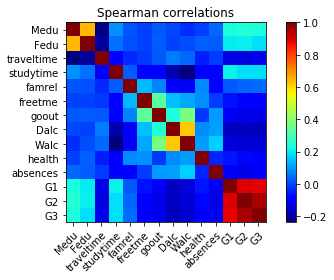

In [51]:
labels = ["Medu", "Fedu", "traveltime", "studytime", "famrel", "freetme", "goout","Dalc","Walc","health","absences", "G1", "G2", "G3"]

fig, ax = plt.subplots()
im = ax.imshow(rho, cmap='jet')

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Spearman correlations")

fig.tight_layout()
fig.colorbar(im)

plt.show()